## Read data matrix

In [1]:
import pandas as pd
import psycopg2

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'omop_cdm'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

dataQuery = """select * from sepsis_icd.data_matrix_2 where sepsis = 1;"""
dataDf = pd.read_sql_query(dataQuery, con)
dataDf

,visit_occurrence_id,person_id,visit_occurrence_concept_name,visit_duration_hrs,visit_source_concept_name,admitting_source_value,temp_max,heartrate_max,breath_rate_vent_max,breath_rate_spon_max,...,bicarbonate_last,hemoglobin_last,creatinine_last,discharge_mortality,one_day_mortality,two_day_mortality,thirty_day_mortality,sixty_day_mortality,ninety_day_mortality,sepsis
0,-2147304039,1052438339,Emergency Room - Hospital,214.0,EW EMER.,EMERGENCY ROOM,36.9,NaN,NaN,NaN,...,29.0,10.8,0.6,False,False,False,False,False,False,1
1,-2147002424,-1242295740,Emergency Room and Inpatient Visit,573.0,URGENT,TRANSFER FROM HOSPITAL,99.1,111.0,NaN,NaN,...,14.0,7.3,0.3,False,False,False,False,False,False,1
2,-2144345945,2004496459,Inpatient Visit,684.0,ELECTIVE,PHYSICIAN REFERRAL,38.3,NaN,NaN,NaN,...,22.0,8.0,1.0,False,False,False,False,False,False,1
3,-2137779334,1692040065,Emergency Room and Inpatient Visit,134.0,URGENT,TRANSFER FROM HOSPITAL,99.0,112.0,14.0,14.0,...,27.0,10.8,0.5,False,False,False,False,False,False,1
4,-2136505586,-647215717,Emergency Room and Inpatient Visit,1240.0,URGENT,TRANSFER FROM HOSPITAL,102.1,141.0,24.0,26.0,...,26.0,8.8,4.9,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11516,2144084743,-543633336,Emergency Room and Inpatient Visit,139.0,URGENT,TRANSFER FROM HOSPITAL,99.1,116.0,16.0,31.0,...,33.0,9.3,0.5,False,False,False,False,False,False,1
11517,2144805894,-251264248,Emergency Room - Hospital,125.0,EW EMER.,EMERGENCY ROOM,99.2,104.0,NaN,NaN,...,24.0,7.2,0.9,False,False,False,False,False,False,1
11518,2145278835,1177429874,Emergency Room - Hospital,553.0,EW EMER.,EMERGENCY ROOM,103.1,125.0,NaN,NaN,...,21.0,8.2,1.8,False,False,False,False,False,False,1
11519,2146770624,-1169554980,Emergency Room - Hospital,127.0,EW EMER.,EMERGENCY ROOM,102.2,109.0,NaN,NaN,...,21.0,8.1,1.0,False,False,False,False,False,False,1


## Missing data

In [2]:
dataDf.isna().sum().sort_values()

visit_occurrence_id        0
sixty_day_mortality        0
thirty_day_mortality       0
two_day_mortality          0
one_day_mortality          0
                        ... 
meanbp_min              7039
meanbp_max              7039
meanbp_first            7039
meanbp_last             7039
meanbp_sd               7053
Length: 145, dtype: int64

<AxesSubplot:>

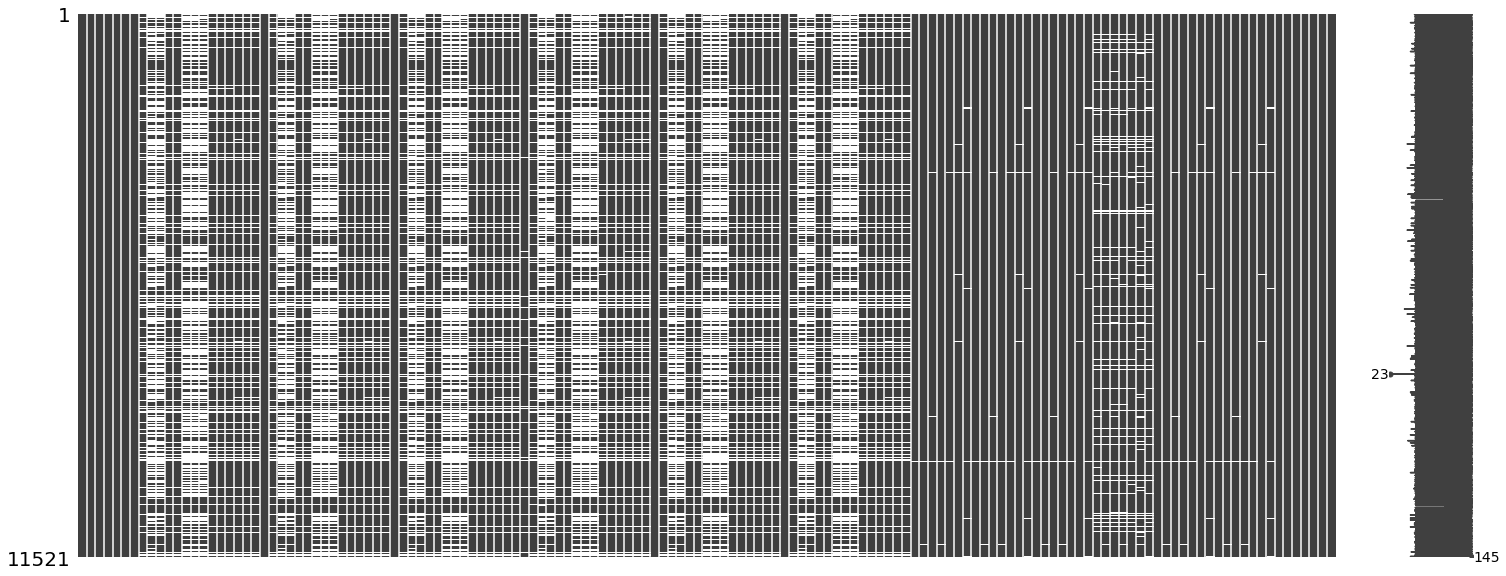

In [3]:
import missingno as msno

msno.matrix(dataDf)

<AxesSubplot:>

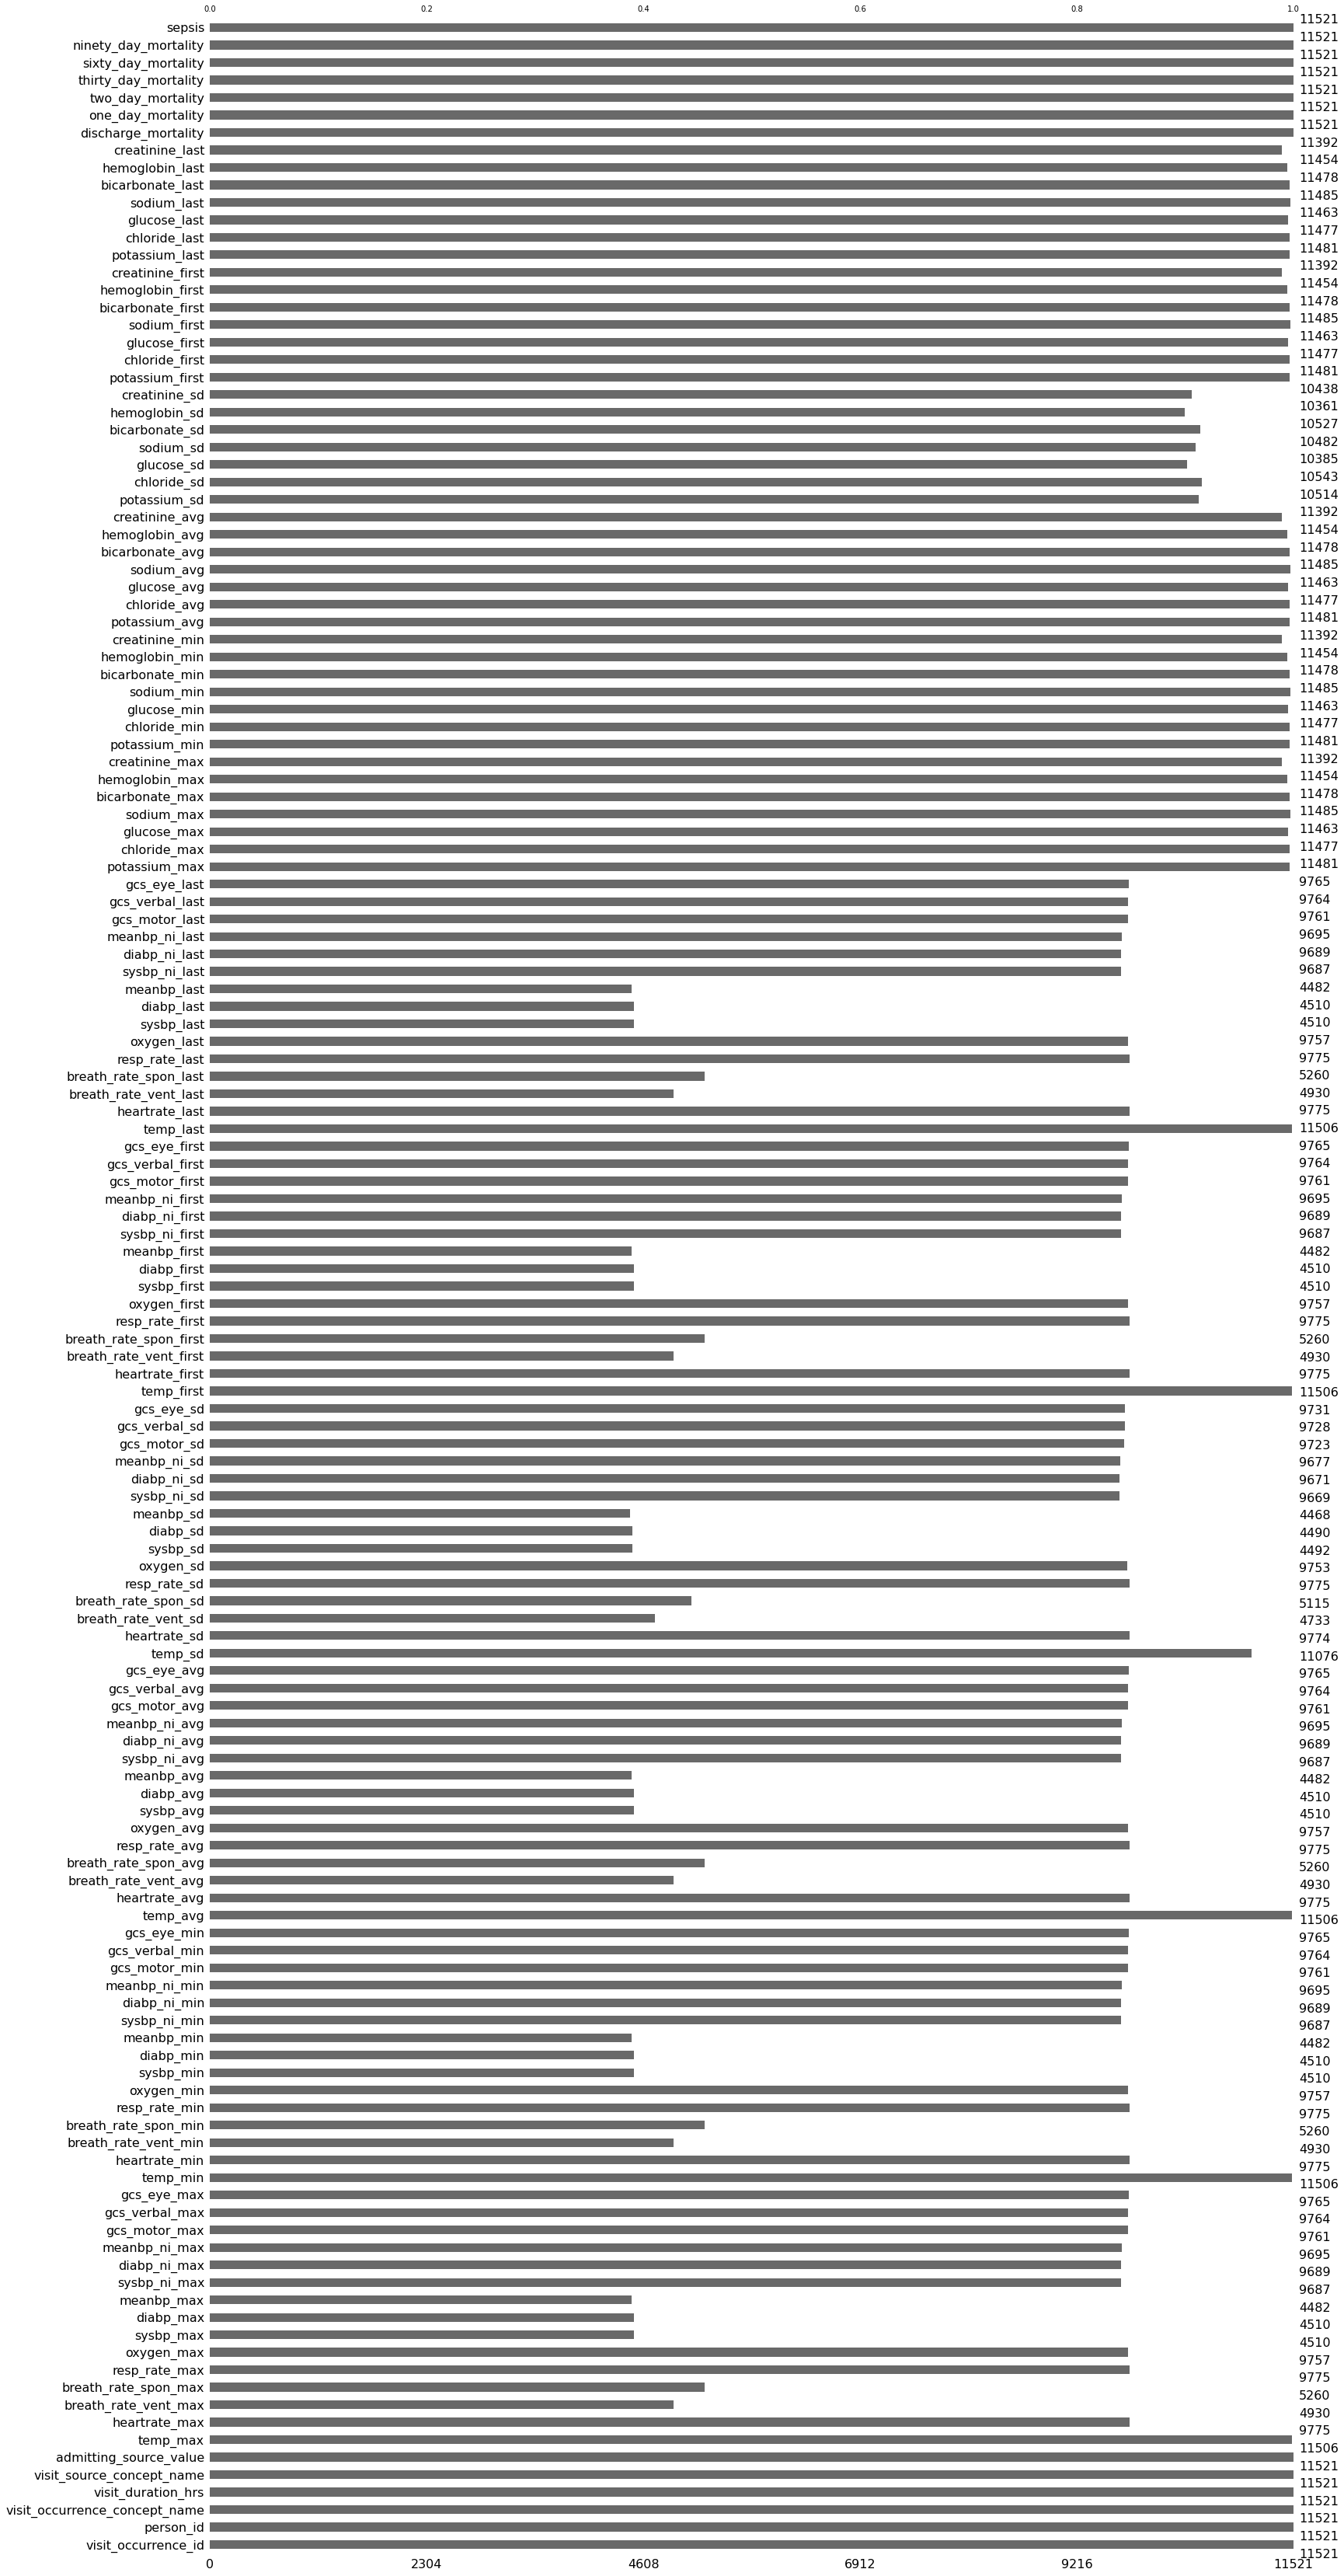

In [4]:
import missingno as msno

msno.bar(dataDf)

## One-hot-encode categorical columns

In [5]:
for catCol in ['visit_occurrence_concept_name', 'visit_source_concept_name', 'admitting_source_value']:
    dummyDf = pd.get_dummies(dataDf[catCol])
    dataDf.drop(catCol, axis = 1, inplace=True)
    dataDf = dataDf.join(dummyDf)
dataDf

,visit_occurrence_id,person_id,visit_duration_hrs,temp_max,heartrate_max,breath_rate_vent_max,breath_rate_spon_max,resp_rate_max,oxygen_max,sysbp_max,...,CLINIC REFERRAL,EMERGENCY ROOM,INFORMATION NOT AVAILABLE,INTERNAL TRANSFER TO OR FROM PSYCH,PACU,PHYSICIAN REFERRAL,PROCEDURE SITE,TRANSFER FROM HOSPITAL,TRANSFER FROM SKILLED NURSING FACILITY,WALK-IN/SELF REFERRAL
0,-2147304039,1052438339,214.0,36.9,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
1,-2147002424,-1242295740,573.0,99.1,111.0,NaN,NaN,39.0,100.0,NaN,...,0,0,0,0,0,0,0,1,0,0
2,-2144345945,2004496459,684.0,38.3,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
3,-2137779334,1692040065,134.0,99.0,112.0,14.0,14.0,28.0,100.0,146.0,...,0,0,0,0,0,0,0,1,0,0
4,-2136505586,-647215717,1240.0,102.1,141.0,24.0,26.0,33.0,100.0,165.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11516,2144084743,-543633336,139.0,99.1,116.0,16.0,31.0,31.0,100.0,NaN,...,0,0,0,0,0,0,0,1,0,0
11517,2144805894,-251264248,125.0,99.2,104.0,NaN,NaN,22.0,100.0,NaN,...,0,1,0,0,0,0,0,0,0,0
11518,2145278835,1177429874,553.0,103.1,125.0,NaN,NaN,39.0,100.0,NaN,...,0,1,0,0,0,0,0,0,0,0
11519,2146770624,-1169554980,127.0,102.2,109.0,NaN,NaN,36.0,100.0,NaN,...,0,1,0,0,0,0,0,0,0,0


## Standardise

In [6]:
cols = ["visit_duration_hrs", "temp_max", "heartrate_max", "breath_rate_vent_max", "breath_rate_spon_max", "resp_rate_max", "oxygen_max", "sysbp_max", "diabp_max", "meanbp_max", "sysbp_ni_max", "diabp_ni_max", "meanbp_ni_max", "gcs_motor_max", "gcs_verbal_max", "gcs_eye_max", "temp_min", "heartrate_min", "breath_rate_vent_min", "breath_rate_spon_min", "resp_rate_min", "oxygen_min", "sysbp_min", "diabp_min", "meanbp_min", "sysbp_ni_min", "diabp_ni_min", "meanbp_ni_min", "gcs_motor_min", "gcs_verbal_min", "gcs_eye_min", "temp_avg", "heartrate_avg", "breath_rate_vent_avg", "breath_rate_spon_avg", "resp_rate_avg", "oxygen_avg", "sysbp_avg", "diabp_avg", "meanbp_avg", "sysbp_ni_avg", "diabp_ni_avg", "meanbp_ni_avg", "gcs_motor_avg", "gcs_verbal_avg", "gcs_eye_avg", "temp_sd", "heartrate_sd", "breath_rate_vent_sd", "breath_rate_spon_sd", "resp_rate_sd", "oxygen_sd", "sysbp_sd", "diabp_sd", "meanbp_sd", "sysbp_ni_sd", "diabp_ni_sd", "meanbp_ni_sd", "gcs_motor_sd", "gcs_verbal_sd", "gcs_eye_sd", "temp_first", "heartrate_first", "breath_rate_vent_first", "breath_rate_spon_first", "resp_rate_first", "oxygen_first", "sysbp_first", "diabp_first", "meanbp_first", "sysbp_ni_first", "diabp_ni_first", "meanbp_ni_first", "gcs_motor_first", "gcs_verbal_first", "gcs_eye_first", "temp_last", "heartrate_last", "breath_rate_vent_last", "breath_rate_spon_last", "resp_rate_last", "oxygen_last", "sysbp_last", "diabp_last", "meanbp_last", "sysbp_ni_last", "diabp_ni_last", "meanbp_ni_last", "gcs_motor_last", "gcs_verbal_last", "gcs_eye_last", "potassium_max", "chloride_max", "glucose_max", "sodium_max", "bicarbonate_max", "hemoglobin_max", "creatinine_max", "potassium_min", "chloride_min", "glucose_min", "sodium_min", "bicarbonate_min", "hemoglobin_min", "creatinine_min", "potassium_avg", "chloride_avg", "glucose_avg", "sodium_avg", "bicarbonate_avg", "hemoglobin_avg", "creatinine_avg", "potassium_sd", "chloride_sd", "glucose_sd", "sodium_sd", "bicarbonate_sd", "hemoglobin_sd", "creatinine_sd", "potassium_first", "chloride_first", "glucose_first", "sodium_first", "bicarbonate_first", "hemoglobin_first", "creatinine_first", "potassium_last", "chloride_last", "glucose_last", "sodium_last", "bicarbonate_last", "hemoglobin_last", "creatinine_last"]

In [7]:
from sklearn.preprocessing import StandardScaler

data = StandardScaler().fit_transform(dataDf[cols])
standardDf = pd.DataFrame(data, columns = cols)
standardDf

,visit_duration_hrs,temp_max,heartrate_max,breath_rate_vent_max,breath_rate_spon_max,resp_rate_max,oxygen_max,sysbp_max,diabp_max,meanbp_max,...,bicarbonate_first,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last
0,-0.298567,-2.312671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.200788,0.333066,-0.815448,-1.186819,-2.843820,2.031557,-0.757336,0.898238,0.816059,-0.736365
1,0.474897,0.388961,-0.286378,NaN,NaN,1.278164,0.318216,NaN,NaN,NaN,...,-2.095619,-0.059306,-0.976023,-0.668035,-0.062589,-0.555414,-0.559555,-1.708890,-1.269585,-0.975811
2,0.714046,-2.251862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.932181,-0.500726,-0.092861,1.234175,-0.835153,0.678372,-0.559555,-0.318422,-0.852456,-0.417104
3,-0.470927,0.384618,-0.234880,-1.187742,-0.806811,-0.776103,0.318216,-0.355044,-0.289811,-0.555223,...,0.231257,0.578299,-0.815448,-0.149250,-0.680640,-0.256918,-1.944020,0.550621,0.816059,-0.816180
4,1.911945,0.519265,1.258572,0.444290,0.172797,0.157655,0.318216,0.490717,1.100091,1.608603,...,-1.126087,-0.598819,1.673464,-0.149250,-0.680640,-0.376316,-0.757336,0.376812,-0.375737,2.695693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11516,-0.460154,0.388961,-0.028886,-0.861335,0.580967,-0.215848,0.318216,NaN,NaN,NaN,...,0.619069,-0.647865,-0.976023,-0.149250,-1.298691,-0.336517,-0.559555,1.593471,-0.077788,-0.816180
11517,-0.490317,0.393305,-0.646867,NaN,NaN,-1.896612,0.318216,NaN,NaN,NaN,...,0.231257,-2.609728,-0.574585,-0.495107,0.555463,-0.595214,0.231568,0.029195,-1.329175,-0.496919
11518,0.431807,0.562700,0.434599,NaN,NaN,1.278164,0.318216,NaN,NaN,NaN,...,-1.126087,-1.236424,-0.173148,0.369534,-0.062589,-0.157419,-0.757336,-0.492230,-0.733276,0.221419
11519,-0.486008,0.523608,-0.389375,NaN,NaN,0.717909,0.318216,NaN,NaN,NaN,...,-0.544368,-0.647865,-0.494298,-1.186819,0.864488,-0.276818,-0.163994,-0.492230,-0.792866,-0.417104


In [8]:
dataDf = dataDf.drop(cols, axis = 1).join(standardDf)
dataDf

,visit_occurrence_id,person_id,discharge_mortality,one_day_mortality,two_day_mortality,thirty_day_mortality,sixty_day_mortality,ninety_day_mortality,sepsis,Ambulatory Clinic / Center,...,bicarbonate_first,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last
0,-2147304039,1052438339,False,False,False,False,False,False,1,0,...,1.200788,0.333066,-0.815448,-1.186819,-2.843820,2.031557,-0.757336,0.898238,0.816059,-0.736365
1,-2147002424,-1242295740,False,False,False,False,False,False,1,0,...,-2.095619,-0.059306,-0.976023,-0.668035,-0.062589,-0.555414,-0.559555,-1.708890,-1.269585,-0.975811
2,-2144345945,2004496459,False,False,False,False,False,False,1,0,...,-0.932181,-0.500726,-0.092861,1.234175,-0.835153,0.678372,-0.559555,-0.318422,-0.852456,-0.417104
3,-2137779334,1692040065,False,False,False,False,False,False,1,0,...,0.231257,0.578299,-0.815448,-0.149250,-0.680640,-0.256918,-1.944020,0.550621,0.816059,-0.816180
4,-2136505586,-647215717,False,False,False,False,False,False,1,0,...,-1.126087,-0.598819,1.673464,-0.149250,-0.680640,-0.376316,-0.757336,0.376812,-0.375737,2.695693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11516,2144084743,-543633336,False,False,False,False,False,False,1,0,...,0.619069,-0.647865,-0.976023,-0.149250,-1.298691,-0.336517,-0.559555,1.593471,-0.077788,-0.816180
11517,2144805894,-251264248,False,False,False,False,False,False,1,0,...,0.231257,-2.609728,-0.574585,-0.495107,0.555463,-0.595214,0.231568,0.029195,-1.329175,-0.496919
11518,2145278835,1177429874,False,False,False,False,False,False,1,0,...,-1.126087,-1.236424,-0.173148,0.369534,-0.062589,-0.157419,-0.757336,-0.492230,-0.733276,0.221419
11519,2146770624,-1169554980,False,False,False,False,False,False,1,0,...,-0.544368,-0.647865,-0.494298,-1.186819,0.864488,-0.276818,-0.163994,-0.492230,-0.792866,-0.417104


In [9]:
dataDf['discharge_mortality'] = dataDf['discharge_mortality'].apply(lambda x: 1 if x else 0)
dataDf['one_day_mortality'] = dataDf['one_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['two_day_mortality'] = dataDf['two_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['thirty_day_mortality'] = dataDf['thirty_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['sixty_day_mortality'] = dataDf['sixty_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['ninety_day_mortality'] = dataDf['ninety_day_mortality'].apply(lambda x: 1 if x else 0)

In [24]:
dataDf

,visit_occurrence_id,person_id,discharge_mortality,one_day_mortality,two_day_mortality,thirty_day_mortality,sixty_day_mortality,ninety_day_mortality,sepsis,Ambulatory Clinic / Center,...,bicarbonate_first,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last
0,-2147304039,1052438339,0,0,0,0,0,0,1,0,...,1.200788,0.333066,-0.815448,-1.186819,-2.843820,2.031557,-0.757336,0.898238,0.816059,-0.736365
1,-2147002424,-1242295740,0,0,0,0,0,0,1,0,...,-2.095619,-0.059306,-0.976023,-0.668035,-0.062589,-0.555414,-0.559555,-1.708890,-1.269585,-0.975811
2,-2144345945,2004496459,0,0,0,0,0,0,1,0,...,-0.932181,-0.500726,-0.092861,1.234175,-0.835153,0.678372,-0.559555,-0.318422,-0.852456,-0.417104
3,-2137779334,1692040065,0,0,0,0,0,0,1,0,...,0.231257,0.578299,-0.815448,-0.149250,-0.680640,-0.256918,-1.944020,0.550621,0.816059,-0.816180
4,-2136505586,-647215717,0,0,0,0,0,0,1,0,...,-1.126087,-0.598819,1.673464,-0.149250,-0.680640,-0.376316,-0.757336,0.376812,-0.375737,2.695693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11516,2144084743,-543633336,0,0,0,0,0,0,1,0,...,0.619069,-0.647865,-0.976023,-0.149250,-1.298691,-0.336517,-0.559555,1.593471,-0.077788,-0.816180
11517,2144805894,-251264248,0,0,0,0,0,0,1,0,...,0.231257,-2.609728,-0.574585,-0.495107,0.555463,-0.595214,0.231568,0.029195,-1.329175,-0.496919
11518,2145278835,1177429874,0,0,0,0,0,0,1,0,...,-1.126087,-1.236424,-0.173148,0.369534,-0.062589,-0.157419,-0.757336,-0.492230,-0.733276,0.221419
11519,2146770624,-1169554980,0,0,0,0,0,0,1,0,...,-0.544368,-0.647865,-0.494298,-1.186819,0.864488,-0.276818,-0.163994,-0.492230,-0.792866,-0.417104


## Missing data imputation

### Import libraries

In [11]:
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import impyute as impy
import miceforest as mf
from statsmodels.multivariate.pca import PCA
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA as sklearnPCA
from MissForest import MissForest
# import datawig

### Obtain rows with no null values

In [25]:
fullDf = dataDf.drop(['visit_occurrence_id', 'person_id'], axis = 1).dropna()

In [26]:
fullDf.shape

(3240, 166)

In [27]:
fullDf

,discharge_mortality,one_day_mortality,two_day_mortality,thirty_day_mortality,sixty_day_mortality,ninety_day_mortality,sepsis,Ambulatory Clinic / Center,Ambulatory Surgical Center,Emergency Room - Hospital,...,bicarbonate_first,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last
3,0,0,0,0,0,0,1,0,0,0,...,0.231257,0.578299,-0.815448,-0.149250,-0.680640,-0.256918,-1.944020,0.550621,0.816059,-0.816180
4,0,0,0,0,0,0,1,0,0,0,...,-1.126087,-0.598819,1.673464,-0.149250,-0.680640,-0.376316,-0.757336,0.376812,-0.375737,2.695693
6,1,1,1,1,1,1,1,0,0,1,...,-0.932181,2.245883,0.067714,2.098815,-1.298691,1.454463,-1.944020,-2.751740,-2.878510,1.578279
7,1,1,1,1,1,1,1,0,0,0,...,0.619069,-1.040238,1.111451,2.617600,-0.835153,-0.197218,0.033787,1.072046,-1.269585,1.338833
8,0,0,0,0,0,0,1,0,0,1,...,0.812975,-0.795005,1.352314,-0.322179,-0.680640,0.021679,0.231568,1.419663,-0.018198,0.939756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11487,1,1,1,1,1,1,1,0,0,0,...,0.425163,0.038787,-0.735160,-0.149250,-0.062589,-0.237018,0.627129,1.767280,0.756469,-0.496919
11501,0,0,0,0,0,0,1,0,0,1,...,-0.738275,-0.353586,-0.012573,-0.840963,0.864488,2.907148,1.022691,-0.318422,-0.494917,-0.097842
11509,1,1,1,1,1,1,1,0,0,1,...,-1.126087,1.215905,0.148002,-0.495107,-0.371614,0.379875,-0.361774,0.724429,0.458520,0.141603
11513,0,0,0,0,0,0,1,0,0,0,...,0.619069,-0.010260,-0.735160,-1.186819,0.091924,-0.575314,0.627129,0.203004,0.220161,-0.656549


### Create missingness

In [28]:
mask = np.random.choice(a=[True, False], size=fullDf.shape, p=[0.1, 0.9])
missingDf = fullDf.mask(mask)

In [29]:
missingDf

,discharge_mortality,one_day_mortality,two_day_mortality,thirty_day_mortality,sixty_day_mortality,ninety_day_mortality,sepsis,Ambulatory Clinic / Center,Ambulatory Surgical Center,Emergency Room - Hospital,...,bicarbonate_first,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last
3,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,...,NaN,0.578299,-0.815448,-0.149250,-0.680640,-0.256918,-1.944020,NaN,0.816059,-0.816180
4,0.0,0.0,NaN,0.0,0.0,0.0,1.0,NaN,0.0,NaN,...,-1.126087,-0.598819,1.673464,-0.149250,-0.680640,-0.376316,-0.757336,0.376812,-0.375737,2.695693
6,1.0,1.0,1.0,1.0,NaN,1.0,1.0,0.0,0.0,1.0,...,-0.932181,2.245883,0.067714,2.098815,-1.298691,1.454463,-1.944020,-2.751740,-2.878510,1.578279
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,...,0.619069,-1.040238,1.111451,2.617600,-0.835153,-0.197218,0.033787,1.072046,NaN,1.338833
8,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,...,0.812975,-0.795005,1.352314,-0.322179,-0.680640,0.021679,0.231568,1.419663,-0.018198,0.939756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11487,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.425163,0.038787,-0.735160,-0.149250,-0.062589,-0.237018,0.627129,1.767280,0.756469,-0.496919
11501,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,1.0,...,NaN,-0.353586,-0.012573,-0.840963,0.864488,2.907148,1.022691,NaN,-0.494917,-0.097842
11509,NaN,1.0,1.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0,...,NaN,1.215905,0.148002,-0.495107,-0.371614,0.379875,-0.361774,0.724429,0.458520,0.141603
11513,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.619069,-0.010260,-0.735160,-1.186819,NaN,-0.575314,0.627129,0.203004,NaN,-0.656549


### Mean imputation

In [30]:
meanImputer = SimpleImputer(strategy='mean')
meanImputedData = meanImputer.fit_transform(missingDf)
meanImputedDf = pd.DataFrame(meanImputedData, columns=[(col + '_mean') for col in missingDf.columns], index=missingDf.index)
meanMse = mean_squared_error(fullDf, meanImputedDf)
meanR2 = r2_score(fullDf, meanImputedDf)
meanMse, meanR2

(0.07681881577792239, 0.901923088220793)

### Median imputation

In [31]:
medianImputer = SimpleImputer(strategy='median')
medianImputedData = medianImputer.fit_transform(missingDf)
medianImputedDf = pd.DataFrame(medianImputedData, columns=[(col + '_median') for col in missingDf.columns], index=missingDf.index)
medianMse = mean_squared_error(fullDf, medianImputedDf)
medianR2 = r2_score(fullDf, medianImputedDf)
medianMse, medianR2

(0.08159427065629664, 0.8936119826051251)

### KNN imputation

In [32]:
knnImputer = KNNImputer()
knnImputedData = knnImputer.fit_transform(missingDf)
knnImputedDf = pd.DataFrame(knnImputedData, columns=[(col + '_knn') for col in missingDf.columns], index=missingDf.index)
knnMse = mean_squared_error(fullDf, knnImputedDf)
knnR2 = r2_score(fullDf, knnImputedDf)
knnMse, knnR2

(0.049249153700315296, 0.9327209052671883)

### MissForest imputation

In [33]:
mfImputer = MissForest()
mfImputedData = mfImputer.fit(missingDf).transform(missingDf)
mfImputedDf = pd.DataFrame(mfImputedData, columns=[(col + '_mf') for col in missingDf.columns], index=missingDf.index)
mfMse = mean_squared_error(fullDf, mfImputedDf)
mfR2 = r2_score(fullDf, mfImputedDf)
mfMse, mfR2

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


(0.021009239536639968, 0.9707239613141376)

### Expectation maximisation imputation

In [34]:
emImputedData = impy.em(missingDf.to_numpy())
emImputedDataDf = pd.DataFrame(emImputedData, columns=[(col + '_em') for col in missingDf.columns], index=missingDf.index)
emMse = mean_squared_error(fullDf, emImputedDataDf)
emR2 = r2_score(fullDf, emImputedDataDf)
emMse, emR2

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/impyute/imputation/cs/em.py:48: RuntimeWarning: invalid value encountered in double_scalars
  delta = (col[x_i]-previous)/previous


(0.13500875862663864, 0.8264188407018354)

### Multiple Imputation

In [35]:
# Create kernel. 
miKernel = mf.ImputationKernel(
  missingDf,
  datasets=4,
  save_all_iterations=True,
  random_state=1
)
# Run the MICE algorithm for 2 iterations on each of the datasets
miKernel.mice(2)
miImputedDataDf = miKernel.complete_data(dataset=0, inplace=False)
miImputedDf = pd.DataFrame(miImputedDataDf.to_numpy(), columns=[(col + '_mi') for col in missingDf.columns], index=missingDf.index)
miMse = mean_squared_error(fullDf, miImputedDf)
miR2 = r2_score(fullDf, miImputedDf)
miMse, miR2

(0.03021801788991221, 0.959877998035072)

### Comparision of different imputation strategies

[Text(0, 0, '0.901923'),
 Text(0, 0, '0.893612'),
 Text(0, 0, '0.932721'),
 Text(0, 0, '0.970724'),
 Text(0, 0, '0.826419'),
 Text(0, 0, '0.959878')]

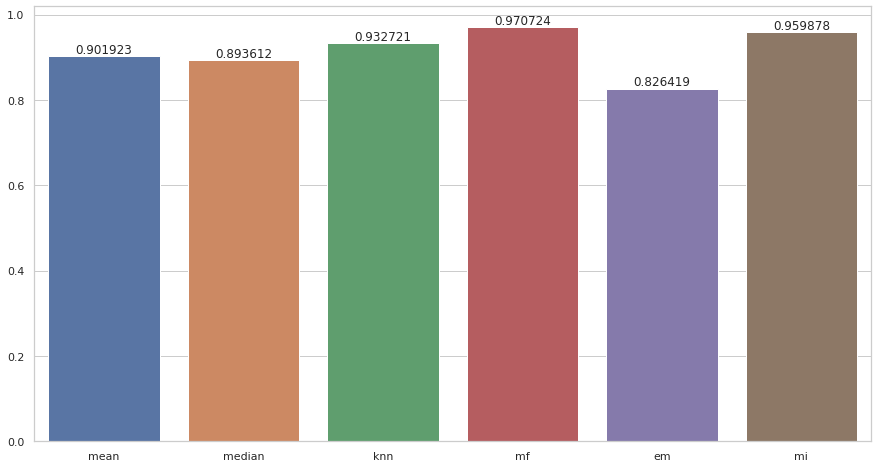

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns

r2Scores = [meanR2, medianR2, knnR2, mfR2, emR2, miR2]
algos = ['mean', 'median', 'knn', 'mf', 'em', 'mi']

sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
ax = sns.barplot(x=algos, y=r2Scores)
ax.bar_label(ax.containers[0])

### Use MissForest to impute missing values

In [38]:
tempDf1 = dataDf.drop(['visit_occurrence_id', 'person_id'], axis = 1)
mfImputer = MissForest()
mfImputedData = mfImputer.fit(tempDf1).transform(tempDf1)
mfImputedDf = pd.DataFrame(mfImputedData, columns=[(col + '_mf') for col in tempDf1.columns], index=tempDf1.index)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


In [39]:
mfImputedDf

,discharge_mortality_mf,one_day_mortality_mf,two_day_mortality_mf,thirty_day_mortality_mf,sixty_day_mortality_mf,ninety_day_mortality_mf,sepsis_mf,Ambulatory Clinic / Center_mf,Ambulatory Surgical Center_mf,Emergency Room - Hospital_mf,...,bicarbonate_first_mf,hemoglobin_first_mf,creatinine_first_mf,potassium_last_mf,chloride_last_mf,glucose_last_mf,sodium_last_mf,bicarbonate_last_mf,hemoglobin_last_mf,creatinine_last_mf
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.200788,0.333066,-0.815448,-1.186819,-2.843820,2.031557,-0.757336,0.898238,0.816059,-0.736365
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-2.095619,-0.059306,-0.976023,-0.668035,-0.062589,-0.555414,-0.559555,-1.708890,-1.269585,-0.975811
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.932181,-0.500726,-0.092861,1.234175,-0.835153,0.678372,-0.559555,-0.318422,-0.852456,-0.417104
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.231257,0.578299,-0.815448,-0.149250,-0.680640,-0.256918,-1.944020,0.550621,0.816059,-0.816180
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.126087,-0.598819,1.673464,-0.149250,-0.680640,-0.376316,-0.757336,0.376812,-0.375737,2.695693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11516,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.619069,-0.647865,-0.976023,-0.149250,-1.298691,-0.336517,-0.559555,1.593471,-0.077788,-0.816180
11517,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.231257,-2.609728,-0.574585,-0.495107,0.555463,-0.595214,0.231568,0.029195,-1.329175,-0.496919
11518,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-1.126087,-1.236424,-0.173148,0.369534,-0.062589,-0.157419,-0.757336,-0.492230,-0.733276,0.221419
11519,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.544368,-0.647865,-0.494298,-1.186819,0.864488,-0.276818,-0.163994,-0.492230,-0.792866,-0.417104


In [41]:
tempDf2 = mfImputedDf.join(dataDf[['visit_occurrence_id', 'person_id']])
tempDf2

,discharge_mortality_mf,one_day_mortality_mf,two_day_mortality_mf,thirty_day_mortality_mf,sixty_day_mortality_mf,ninety_day_mortality_mf,sepsis_mf,Ambulatory Clinic / Center_mf,Ambulatory Surgical Center_mf,Emergency Room - Hospital_mf,...,creatinine_first_mf,potassium_last_mf,chloride_last_mf,glucose_last_mf,sodium_last_mf,bicarbonate_last_mf,hemoglobin_last_mf,creatinine_last_mf,visit_occurrence_id,person_id
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.815448,-1.186819,-2.843820,2.031557,-0.757336,0.898238,0.816059,-0.736365,-2147304039,1052438339
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.976023,-0.668035,-0.062589,-0.555414,-0.559555,-1.708890,-1.269585,-0.975811,-2147002424,-1242295740
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.092861,1.234175,-0.835153,0.678372,-0.559555,-0.318422,-0.852456,-0.417104,-2144345945,2004496459
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.815448,-0.149250,-0.680640,-0.256918,-1.944020,0.550621,0.816059,-0.816180,-2137779334,1692040065
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.673464,-0.149250,-0.680640,-0.376316,-0.757336,0.376812,-0.375737,2.695693,-2136505586,-647215717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11516,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.976023,-0.149250,-1.298691,-0.336517,-0.559555,1.593471,-0.077788,-0.816180,2144084743,-543633336
11517,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.574585,-0.495107,0.555463,-0.595214,0.231568,0.029195,-1.329175,-0.496919,2144805894,-251264248
11518,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.173148,0.369534,-0.062589,-0.157419,-0.757336,-0.492230,-0.733276,0.221419,2145278835,1177429874
11519,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.494298,-1.186819,0.864488,-0.276818,-0.163994,-0.492230,-0.792866,-0.417104,2146770624,-1169554980


In [43]:
import os

outPath = os.getcwd() + '/data/data_matrix_original.csv'
tempDf2.to_csv(outPath)

## Anomaly detection

In [ ]:
anomalyPath = os.getcwd() + '/data/data_matrix_original.csv'
anomaliesDf = pd.read_csv(anomalyPath)

In [ ]:
anomalies_df['ensemble_scores'].hist()